In [2]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm,binom
from scipy.io import loadmat
from scipy.special import digamma, gammaln, gamma
from numpy.linalg import inv
#import cv2
from scipy import ndimage
import tensorflow as tf

In [16]:
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.models import Model, Input
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [3]:
# Output original images
images_gray = np.load('gray_scale.npy')


In [21]:
# Generate the kernel required
kernel_size = 5
Kernel_num = 1
Kernel  = np.random.rand(kernel_size,kernel_size,Kernel_num)

In [22]:
# definition to project the kernel
def project_kernel(Kernel):
    Kernel_num = Kernel.shape[2]
    for i in range(Kernel_num):
        tmp = Kernel[:,:,i]
        if(np.linalg.norm(tmp,'fro')>0):
            Kernel[:,:,i]=Kernel[:,:,i]/np.linalg.norm(tmp,'fro')
        else:
            Kernel[:,:,i] = Kernel[:,:,i]
    return Kernel

In [23]:
A0 = project_kernel(Kernel)

In [24]:
images_conv = np.zeros_like(images_gray)

In [25]:
for i in range(images_conv.shape[0]):
    images_conv[i] = ndimage.convolve(images_gray[i], A0[:,:,0], mode='constant', cval=1.0)

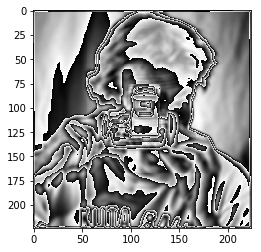

In [26]:
plt.imshow(images_conv[300],cmap='gray')
plt.show()

In [52]:
num_train = 22000
num_val = 500
num_test = 2500

X_train = images_conv[:num_train]
Y_train = images_gray[:num_train]
X_val = images_conv[num_train:num_train+num_val]
Y_val = images_gray[num_train:num_train+num_val]
X_test = images_conv[num_train+num_val:]
Y_test = images_gray[num_train+num_val:]


X_train = X_train.reshape((22000,224,224,1))/255
Y_train = Y_train.reshape((22000,224,224,1))/255
X_val = X_val.reshape((500,224,224,1))/255
Y_val = Y_val.reshape((500,224,224,1))/255
X_test = X_test.reshape((2500,224,224,1))/255
Y_test = Y_test.reshape((2500,224,224,1))/255

MemoryError: 

In [50]:
np.min(X_train[0,:,:,0])

0

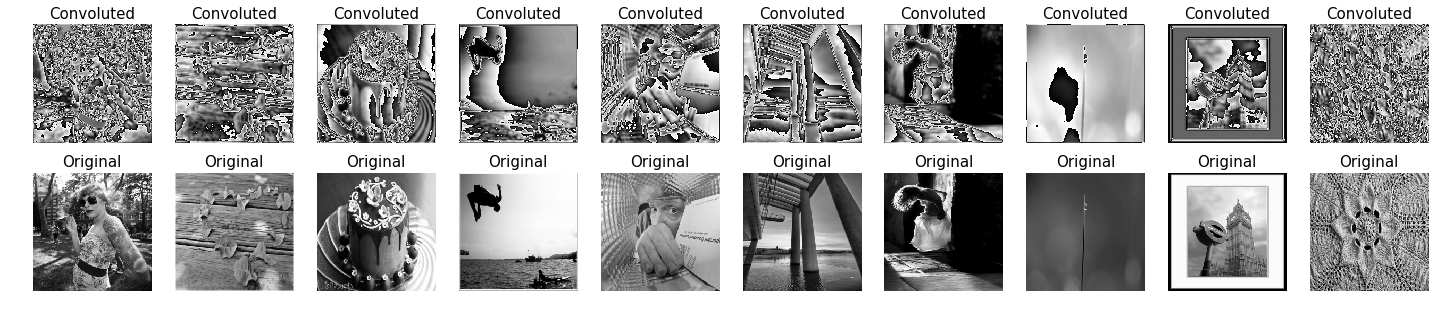

In [35]:
f, ax = plt.subplots(2,10,figsize=(25,5))
for i in range(10):
    ax[0,i].imshow(X_train[i,:,:,0].astype('uint8'),cmap='gray');  ax[0,i].axis('Off'); ax[0,i].set_title('Convoluted', size=15)
    ax[1,i].imshow(Y_train[i,:,:,0].astype('uint8'),cmap='gray');  ax[1,i].axis('Off'); ax[1,i].set_title('Original', size=15)
plt.show()

In [43]:
deblur_CNN_input = Input(shape=(224,224,1))

#HIDDEN LAYERS
deblur_CNN_layer1 = Conv2D(filters=16, kernel_size=7, strides = 1, padding='same')(deblur_CNN_input)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer1)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer1)

deblur_CNN_layer2 = Conv2D(filters=16, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer1)
deblur_CNN_layer2 = BatchNormalization()(deblur_CNN_layer2)
deblur_CNN_layer2 = Activation('relu')(deblur_CNN_layer2)

deblur_CNN_layer3 = Conv2D(filters=16, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer2)
deblur_CNN_layer3 = BatchNormalization()(deblur_CNN_layer3)
deblur_CNN_layer3 = Activation('relu')(deblur_CNN_layer3)

deblur_CNN_output = Conv2D(filters=1, kernel_size=3, strides = 1, padding='same', activation='relu')(deblur_CNN_layer2)

deblur_CNN = Model(inputs= deblur_CNN_input, outputs=deblur_CNN_output )

In [44]:
deblur_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 16)      800       
_________________________________________________________________
batch_normalization_10 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
activation_10 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 16)      6416      
_________________________________________________________________
batch_normalization_11 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
activation_11 (Activation)   (None, 224, 224, 16)      0         
__________

In [45]:
adam = Adam(lr= 0.00001)
deblur_CNN.compile(optimizer= adam, loss= 'mean_squared_error')

In [48]:
deblur_CNN.fit(X_train, Y_train,batch_size = 256, epochs=5)

Epoch 1/5
 6656/22000 [========>.....................] - ETA: 1:15 - loss: 16112.4605

KeyboardInterrupt: 